In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Multi channel attribution modeling
There are several models in the market aiming to solve the customer acquisition problem for marketing. These models are:
- First touch attribution modeling, which gives all the credit to first interaction
- Last touch attribution modeling, gives all credit to the last interaction 
- Linear model, gives equal credits to all the touch points 
- Markov chain, a probability based model 

Each of these models have their pros and cons. 

**Data Analysis and Preprocessing**

In [4]:
df = pd.read_csv('attribution data.csv')
df

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [6]:
df.conversion.value_counts()

0    569098
1     17639
Name: conversion, dtype: int64

we see that there are five different channels.

In [7]:
df.channel.value_counts()

Facebook          175741
Paid Search       151440
Online Video      113302
Instagram          75201
Online Display     71053
Name: channel, dtype: int64

In [8]:
df.describe()

,conversion,conversion_value
count,586737.000000,586737.000000
mean,0.030063,0.187871
std,0.170760,1.084498
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,8.500000


Some data statistics:

In [9]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Overall conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total conversion value : ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Overall conversion rate: 3%
Total conversion value : $110231
Average conversion value: $6


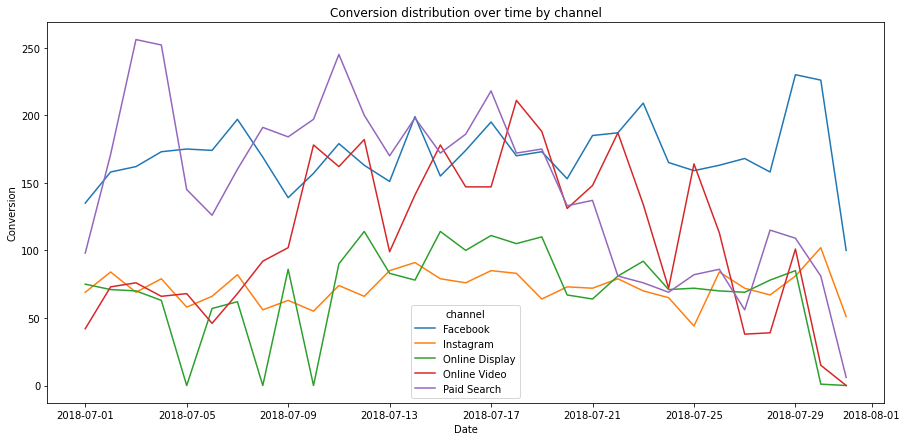

In [10]:
fig, ax = plt.subplots(figsize = (15, 7))
#convert time to datetime 
df.loc[:,'time'] = pd.to_datetime(df['time']).dt.date
grouped_df =  df.groupby(['time','channel'], as_index=False).sum()
sns.lineplot(ax=ax,data=grouped_df, x='time', y='conversion', hue='channel')

# set axes labels
plt.title('Conversion distribution over time by channel')
plt.xlabel('Date')
plt.ylabel('Conversion')

# show the plot
plt.show()

We see that paid search and facebook are almost creating equal conversions till middle of the month in July, 2018. But after first two weeks we see that there is descrease in the paid search conversions. Facebook continue to be the leading channel until end of the month. In addition to that, we see that instagram conversion rate is quite consistent.

Modeling

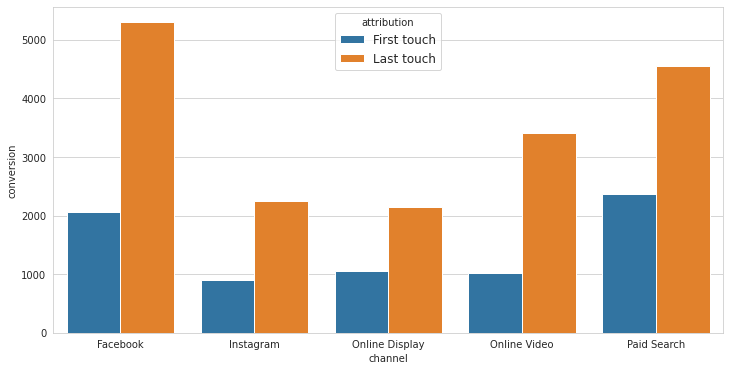

In [11]:


# First touch attribution model
first_touch_df = df.drop_duplicates('cookie', keep='first')[['cookie','channel','conversion', 'conversion_value']]
first_touch_df.loc[:, "attribution"]="First touch"
first_touch_grouped = first_touch_df.groupby(['channel', 'attribution']).sum().reset_index()
# Last touch attribution model
last_touch_df = df.drop_duplicates('cookie', keep='last')[['cookie','channel','conversion', 'conversion_value']]
last_touch_df.loc[:, "attribution"]="Last touch"
last_touch_grouped = last_touch_df.groupby(['channel', 'attribution']).sum().reset_index()

all_attr_df = pd.concat([first_touch_grouped, last_touch_grouped])
# Visualize the attributions
sns.set_style("whitegrid")
plt.rc('legend', fontsize=12)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='channel', y='conversion', hue='attribution', data=all_attr_df)
plt.show()


In [12]:
# aggregate the all the touch points 

path_df = df.groupby('cookie').agg(channels = ("channel",lambda x: x.tolist()),
                                              conversion=("conversion", "sum"),
                                              total_conversion_value=("conversion_value", "sum")).reset_index()

path_df.loc[:,'path']=path_df.apply(lambda x: ["Start",*x['channels'],"Not Converted"] 
                                    if (x['conversion']==0) else 
                                    ["Start",*x['channels'],"Converted"], axis=1)
path_df.head()

,cookie,channels,conversion,total_conversion_value,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0,"[Start, Instagram, Online Display, Online Disp..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0,"[Start, Paid Search, Paid Search, Paid Search,..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0,"[Start, Paid Search, Paid Search, Paid Search,..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0,"[Start, Instagram, Not Converted]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0,"[Start, Paid Search, Not Converted]"


In [13]:
# create transition matrix 
states = ['Start', 'Facebook', 'Instagram', 'Online Display', 
                           'Online Video', 'Paid Search', 'Converted', 'Not Converted'] 

state_dict = {s:i for i,s in enumerate(states)}
trans_mat = [[0]*len(states) for _ in range(len(states))]

for path in path_df['path']:
  for i,j in zip(path, path[1:]):
    trans_mat[state_dict[i]][state_dict[j]] +=1
    
#now convert to probabilities:
for row in trans_mat:
    s = sum(row)
    if s > 0:
        row[:] = [f/s for f in row]
print(trans_mat)


[[0.0, 0.2784080497109634, 0.11918803205224315, 0.14264414346877238, 0.14236093757808985, 0.31739883718993117, 0.0, 0.0], [0.0, 0.3731400185500253, 0.15939365316004803, 0.01819723342873888, 0.021986901178438725, 0.034010276486420354, 0.030163706818556853, 0.36310821037777186], [0.0, 0.3725216419994415, 0.15958564380792808, 0.018683262190662357, 0.022247044587173043, 0.033350620337495515, 0.0298400287230223, 0.3637717583542772], [0.0, 0.04899159782134463, 0.021068779643364812, 0.3490070792225522, 0.01645250728329557, 0.07735071003335538, 0.03010428834813449, 0.45702503764795294], [0.0, 0.03476549398951475, 0.01449224197278071, 0.009893911846216307, 0.6060616758750949, 0.024677410813577872, 0.030078904167622815, 0.28003036133519266], [0.0, 0.052053618594823034, 0.022655837295298468, 0.04147517168515584, 0.024735868991019545, 0.38598124669836237, 0.030025092445853142, 0.44307316428948756], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


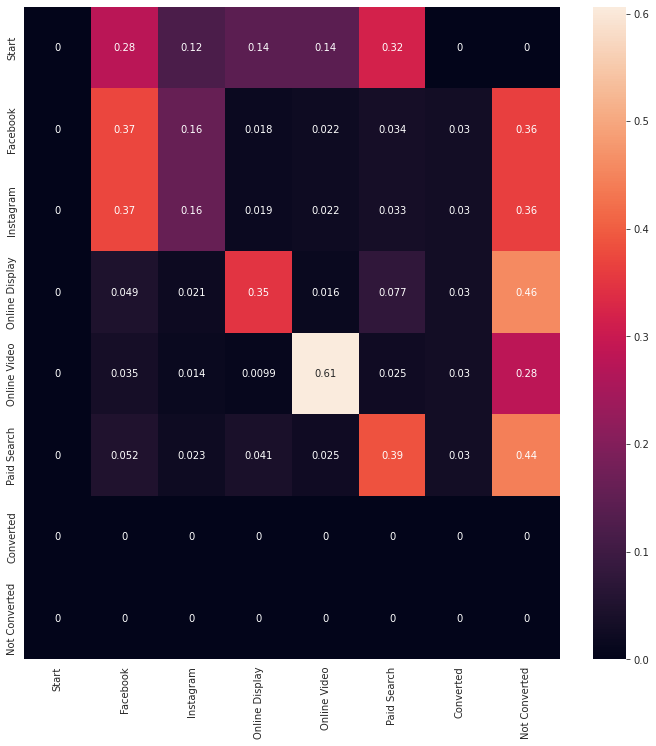

In [14]:
fig,ax = plt.subplots(figsize=(12,12))
transition_df = pd.DataFrame(trans_mat, columns = states, index=states)
sns.heatmap(transition_df, annot=True, ax=ax)
plt.show()

The heatmap of the transition matrix shows us probability of the interaction between pairs of media channels (row to column). From the figure, we see that from any media channel to "Converted" (conversion) probability is 0.03. Even though, all the channels are equally likely to be "Converted", Online Display and Paid Search has higher prorabilities, 0.46 and 0.44 respectively to "Not Converted".

In [24]:
import numpy as np 
def normalize_rows(matrix):
    size = matrix.shape[0]
    mean = matrix.sum(axis=1).reshape((size, 1))
    mean = np.where(mean == 0, 1, mean)
    return matrix / mean

def calc_conversion(matrix):
    matrix = normalize_rows(matrix)

    # remove the converted and non converted states 
    Q = matrix[:-2, :-2]
    R = matrix[:-2, -2:]
    N = np.linalg.inv(np.identity(len(Q)) - Q)

    # also first row represents the start state 
    return (N @ R)[0, 1]

matrix = np.asmatrix(trans_mat)
size = matrix.shape[0]
conversions = np.zeros(size)
for column in range(1, size - 2):
    tmp_matrix = matrix.copy()
    tmp_matrix[:, -2] = tmp_matrix[:, -2] + tmp_matrix[:, column]
    tmp_matrix[:, column] = 0
    conversions[column] = calc_conversion(tmp_matrix)
conversion_orig = calc_conversion(matrix)
removal_effect_results = (1 - (conversions / conversion_orig))[1:-2]

removal_effect_df = pd.DataFrame({"channel":states[1:-2], "removal_effect":removal_effect_results})
print(removal_effect_df)

          channel  removal_effect
0        Facebook        0.398750
1       Instagram        0.230590
2  Online Display        0.191617
3    Online Video        0.180331
4     Paid Search        0.381856


When we calculated the removal effect we see that Facebook and Paid Search have the highest contribution to conversion with similar removal effect values. 